# **Graph Cricket: Predicting Player Performance across ODI Format Using Graph Neural Networks**

Graph Cricket shows a new way to use Graph Neural Networks (GNNs) to forecast how a cricket player would do in ODI format. We create a graph representation with players as nodes and edges capturing relationships between them using a comprehensive dataset that contains statistical information for players from different countries. This data includes total runs, strike rate, average, and the number of 50s and 100s scored in their careers. Our approach makes use of a Graphical Convolutional Network to make use of the cricket player graph's intrinsic structural dependencies. Our approach can learn robust representations that capture performance patterns across the ODI format because it encodes not just the statistical features but also the relationship structure of players. We also used Machine learning models like Linear Regression, Random Forest, KNeighbors, and Decision Tree algorithms to predict the average of the players and then compare this accuracy with the GCN model accuracy. After putting Graph Cricket through its paces on the cricket dataset, it has shown encouraging results, surpassing more conventional methods of predicting players' performances. Our algorithm does more than just forecast performance numbers for players; it also sheds light on what makes a player successful in different forms. Graph Cricket is a game-changer in cricket analytics; it gives analysts, selectors, and coaches a great resource for finding talent and making smart decisions. Our methodology can be applied to other sports domains and to a large variety of prediction tasks, which suggests that it could have broader uses in sports analytics and beyond.

# **1. Installing the necessary libraries**

In [ ]:
# This will take 30-45 mins to install the torch libraries
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-1.8.0+${CUDA}.html
!pip install torch-geometric

# **2. Importing the libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import networkx as nx

# **3. Import and Read the dataset csv file**

In [ ]:
odi = pd.read_csv('/content/ODI data.csv')

In [ ]:
#Number of rows and Columns
odi.shape

(2500, 15)

In [ ]:
# Printing first 10 rows of data
odi.head(10)

,int_player_id,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Unnamed: 13
0,0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,NaN
1,1,KC Sangakkara (SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,NaN
2,2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,NaN
3,3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.2,28,68,34,NaN
4,4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,NaN
5,5,Inzamam-ul-Haq (Asia/PAK),1991-2007,378,350,53,11739,137*,39.52,15812,74.24,10,83,20,NaN
6,6,V Kohli (INDIA),2008-2019,242,233,39,11609,183,59.84,12445,93.28,43,55,13,NaN
7,7,JH Kallis (Afr/ICC/SA),1996-2014,328,314,53,11579,139,44.36,15885,72.89,17,86,17,NaN
8,8,SC Ganguly (Asia/INDIA),1992-2007,311,300,23,11363,183,41.02,15416,73.7,22,72,16,NaN
9,9,R Dravid (Asia/ICC/INDIA),1996-2011,344,318,40,10889,153,39.16,15284,71.24,12,83,13,NaN


In [ ]:
#data types check
odi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   int_player_id  2500 non-null   int64  
 1   Player         2500 non-null   object 
 2   Span           2500 non-null   object 
 3   Mat            2500 non-null   int64  
 4   Inns           2500 non-null   object 
 5   NO             2500 non-null   object 
 6   Runs           2500 non-null   object 
 7   HS             2500 non-null   object 
 8   Ave            2500 non-null   object 
 9   BF             2500 non-null   object 
 10  SR             2500 non-null   object 
 11  100            2500 non-null   object 
 12  50             2500 non-null   object 
 13  0              2500 non-null   object 
 14  Unnamed: 13    0 non-null      float64
dtypes: float64(1), int64(2), object(12)
memory usage: 293.1+ KB


In [ ]:
#summary check
odi.describe()

,int_player_id,Mat,Unnamed: 13
count,2500.000000,2500.000000,0.0
mean,24.500000,37.161600,NaN
std,14.433757,58.885075,NaN
min,0.000000,1.000000,NaN
25%,12.000000,4.000000,NaN
50%,24.500000,13.000000,NaN
75%,37.000000,43.000000,NaN
max,49.000000,463.000000,NaN


In [ ]:
#check for null values
odi.columns[odi.isnull().any()], odi.isnull().sum()

(Index(['Unnamed: 13'], dtype='object'),
 int_player_id       0
 Player              0
 Span                0
 Mat                 0
 Inns                0
 NO                  0
 Runs                0
 HS                  0
 Ave                 0
 BF                  0
 SR                  0
 100                 0
 50                  0
 0                   0
 Unnamed: 13      2500
 dtype: int64)

# **4. Data Preprocessing**

In [ ]:
#delete int_player_id and Unnamed: 13 column
odi = odi.drop(['int_player_id', 'Unnamed: 13'], axis=1)
odi.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.2,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [ ]:
#remove "(" from column player and split into region column
odi[['Player', 'Region']] = odi['Player'].str.split("(", n=1, expand=True)
odi.head()
# If this cell throw an error, kindly run the code from the start again

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Region
0,SR Tendulkar,1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,INDIA)
1,KC Sangakkara,2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,SL)
2,RT Ponting,1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,AUS/ICC)
3,ST Jayasuriya,1989-2011,445,433,18,13430,189,32.36,14725,91.2,28,68,34,Asia/SL)
4,DPMD Jayawardene,1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,Asia/SL)


In [ ]:
#removing ) from region column
odi['Region'] = odi['Region'].map(lambda x: x.rstrip(')'))
odi.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Region
0,SR Tendulkar,1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,INDIA
1,KC Sangakkara,2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,SL
2,RT Ponting,1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,AUS/ICC
3,ST Jayasuriya,1989-2011,445,433,18,13430,189,32.36,14725,91.2,28,68,34,Asia/SL
4,DPMD Jayawardene,1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,Asia/SL


In [ ]:
#split span column into start and end year
odi[['Start', 'End']] = odi['Span'].str.split("-", n=1, expand=True)
odi.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Region,Start,End
0,SR Tendulkar,1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,INDIA,1989,2012
1,KC Sangakkara,2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,SL,2000,2015
2,RT Ponting,1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,AUS/ICC,1995,2012
3,ST Jayasuriya,1989-2011,445,433,18,13430,189,32.36,14725,91.2,28,68,34,Asia/SL,1989,2011
4,DPMD Jayawardene,1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,Asia/SL,1998,2015


In [ ]:
#split region column into region1 and region2
odi[['Region1', 'Region']] = odi['Region'].str.split("/", n=1, expand=True)
odi.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Region,Start,End,Region1
0,SR Tendulkar,1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,None,1989,2012,INDIA
1,KC Sangakkara,2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,None,2000,2015,SL
2,RT Ponting,1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,ICC,1995,2012,AUS
3,ST Jayasuriya,1989-2011,445,433,18,13430,189,32.36,14725,91.2,28,68,34,SL,1989,2011,Asia
4,DPMD Jayawardene,1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,SL,1998,2015,Asia


In [ ]:
#split region1 column into region2
odi[['Region2', 'Region']] = odi['Region'].str.split("/", n=1, expand=True)
odi.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Region,Start,End,Region1,Region2
0,SR Tendulkar,1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,None,1989,2012,INDIA,None
1,KC Sangakkara,2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,None,2000,2015,SL,None
2,RT Ponting,1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,None,1995,2012,AUS,ICC
3,ST Jayasuriya,1989-2011,445,433,18,13430,189,32.36,14725,91.2,28,68,34,None,1989,2011,Asia,SL
4,DPMD Jayawardene,1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,None,1998,2015,Asia,SL


In [ ]:
#unique values in region1
print("Region1 unique values are: ", odi.Region1.unique())
print("Region2 unique values are: ", odi.Region2.unique())
print("Region unique values are: ", odi.Region.unique())

Region1 unique values are:  ['INDIA' 'SL' 'AUS' 'Asia' 'Afr' 'ICC' 'PAK' 'WI' 'NZ' 'SA' 'ENG' 'BDESH'
 'ZIM' 'IRE' 'AFG' 'SCOT' 'KENYA' 'CAN' 'NL' 'UAE' 'HKG' 'BMUDA' 'PNG'
 'USA' 'NAM' 'NEPAL' 'OMAN' '3) (PAK' 'EAf' '1) (UAE']
Region2 unique values are:  [None 'ICC' 'SL' 'PAK' 'INDIA' 'WI' 'SA' 'NZ' 'IRE' 'ZIM' 'BDESH' 'KENYA'
 'PNG' 'SCOT' 'USA']
Region unique values are:  [None 'SA' 'INDIA' 'PAK' 'SL']


In [ ]:
def new_co(odi):
    if odi['Region1'] is not None:
        if odi['Region1'].isupper():
            if (odi.Region1=='ICC'):
                return odi['Region2']
            else:
                return odi['Region1']

        elif odi['Region'] is not None:
            if odi['Region'].isupper():
                if odi['Region'] is not "ICC":
                    return odi['Region']
            else:
                return odi['Region2']
        else:
                return odi['Region2']
    else:
        return "NA"

In [ ]:
odi['Final Region'] = odi.apply(new_co, axis=1)
odi

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Region,Start,End,Region1,Region2,Final Region
0,SR Tendulkar,1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,None,1989,2012,INDIA,None,INDIA
1,KC Sangakkara,2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,None,2000,2015,SL,None,SL
2,RT Ponting,1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,None,1995,2012,AUS,ICC,AUS
3,ST Jayasuriya,1989-2011,445,433,18,13430,189,32.36,14725,91.2,28,68,34,None,1989,2011,Asia,SL,SL
4,DPMD Jayawardene,1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,None,1998,2015,Asia,SL,SL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,ZS Ansari,2015-2015,1,-,-,-,-,-,-,-,-,-,-,None,2015,2015,ENG,None,ENG
2496,Ariful Haque,2018-2018,1,-,-,-,-,-,-,-,-,-,-,None,2018,2018,BDESH,None,BDESH
2497,Ashfaq Ahmed,1994-1994,3,-,-,-,-,-,-,-,-,-,-,None,1994,1994,PAK,None,PAK
2498,MD Bailey,1998-1998,1,-,-,-,-,-,-,-,-,-,-,None,1998,1998,NZ,None,NZ


In [ ]:
odi["Final Region"].unique()

array(['INDIA', 'SL', 'AUS', 'PAK', 'SA', 'WI', 'NZ', 'ENG', 'BDESH',
       'ZIM', 'IRE', 'KENYA', 'AFG', 'SCOT', 'CAN', 'NL', 'UAE', 'HKG',
       'BMUDA', 'PNG', 'USA', 'NAM', 'NEPAL', 'OMAN', '3) (PAK', None,
       '1) (UAE'], dtype=object)

In [ ]:
#check null values in final region
print(odi["Final Region"].isnull().sum())

13


In [ ]:
#drop region1, region2, region columns
odi = odi.drop(["Region1", "Region2", "Region"], axis=1)
odi.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Start,End,Final Region
0,SR Tendulkar,1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,1989,2012,INDIA
1,KC Sangakkara,2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,2000,2015,SL
2,RT Ponting,1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,1995,2012,AUS
3,ST Jayasuriya,1989-2011,445,433,18,13430,189,32.36,14725,91.2,28,68,34,1989,2011,SL
4,DPMD Jayawardene,1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,1998,2015,SL


In [ ]:
odi = odi.drop([2148, 949])
odi

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Start,End,Final Region
0,SR Tendulkar,1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,1989,2012,INDIA
1,KC Sangakkara,2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,2000,2015,SL
2,RT Ponting,1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,1995,2012,AUS
3,ST Jayasuriya,1989-2011,445,433,18,13430,189,32.36,14725,91.2,28,68,34,1989,2011,SL
4,DPMD Jayawardene,1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,1998,2015,SL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,ZS Ansari,2015-2015,1,-,-,-,-,-,-,-,-,-,-,2015,2015,ENG
2496,Ariful Haque,2018-2018,1,-,-,-,-,-,-,-,-,-,-,2018,2018,BDESH
2497,Ashfaq Ahmed,1994-1994,3,-,-,-,-,-,-,-,-,-,-,1994,1994,PAK
2498,MD Bailey,1998-1998,1,-,-,-,-,-,-,-,-,-,-,1998,1998,NZ


In [ ]:
odi["Final Region"].unique()

array(['INDIA', 'SL', 'AUS', 'PAK', 'SA', 'WI', 'NZ', 'ENG', 'BDESH',
       'ZIM', 'IRE', 'KENYA', 'AFG', 'SCOT', 'CAN', 'NL', 'UAE', 'HKG',
       'BMUDA', 'PNG', 'USA', 'NAM', 'NEPAL', 'OMAN', None], dtype=object)

In [ ]:
#Rmoving data of East African Region
odi=odi[odi['Final Region'].isnull()==False]

In [ ]:
odi["Final Region"].unique()

array(['INDIA', 'SL', 'AUS', 'PAK', 'SA', 'WI', 'NZ', 'ENG', 'BDESH',
       'ZIM', 'IRE', 'KENYA', 'AFG', 'SCOT', 'CAN', 'NL', 'UAE', 'HKG',
       'BMUDA', 'PNG', 'USA', 'NAM', 'NEPAL', 'OMAN'], dtype=object)

In [ ]:
#check null values in final region
odi[odi["Final Region"].isnull()]
odi.isna().sum()

Player          0
Span            0
Mat             0
Inns            0
NO              0
Runs            0
HS              0
Ave             0
BF              0
SR              0
100             0
50              0
0               0
Start           0
End             0
Final Region    0
dtype: int64

In [ ]:
#removing * from HS column
odi["HS"] = odi["HS"].str.replace('*', '')
odi.tail()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Start,End,Final Region
2495,ZS Ansari,2015-2015,1,-,-,-,-,-,-,-,-,-,-,2015,2015,ENG
2496,Ariful Haque,2018-2018,1,-,-,-,-,-,-,-,-,-,-,2018,2018,BDESH
2497,Ashfaq Ahmed,1994-1994,3,-,-,-,-,-,-,-,-,-,-,1994,1994,PAK
2498,MD Bailey,1998-1998,1,-,-,-,-,-,-,-,-,-,-,1998,1998,NZ
2499,GR Beard,1981-1981,2,-,-,-,-,-,-,-,-,-,-,1981,1981,AUS


In [ ]:
#replacing - with 0 in odi data
odi.replace('-', 0, inplace=True)
odi.tail()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Start,End,Final Region
2495,ZS Ansari,2015-2015,1,0,0,0,0,0,0,0,0,0,0,2015,2015,ENG
2496,Ariful Haque,2018-2018,1,0,0,0,0,0,0,0,0,0,0,2018,2018,BDESH
2497,Ashfaq Ahmed,1994-1994,3,0,0,0,0,0,0,0,0,0,0,1994,1994,PAK
2498,MD Bailey,1998-1998,1,0,0,0,0,0,0,0,0,0,0,1998,1998,NZ
2499,GR Beard,1981-1981,2,0,0,0,0,0,0,0,0,0,0,1981,1981,AUS


In [ ]:
#check datatypes of Runs, Ave, HS, and SR
odi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2485 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Player        2485 non-null   object
 1   Span          2485 non-null   object
 2   Mat           2485 non-null   int64 
 3   Inns          2485 non-null   object
 4   NO            2485 non-null   object
 5   Runs          2485 non-null   object
 6   HS            2485 non-null   object
 7   Ave           2485 non-null   object
 8   BF            2485 non-null   object
 9   SR            2485 non-null   object
 10  100           2485 non-null   object
 11  50            2485 non-null   object
 12  0             2485 non-null   object
 13  Start         2485 non-null   object
 14  End           2485 non-null   object
 15  Final Region  2485 non-null   object
dtypes: int64(1), object(15)
memory usage: 330.0+ KB


In [ ]:
#Change datatype of Runs, Ave, HS, and SR to floats
odi[['Runs', 'Ave', 'HS', 'SR']] = odi[['Runs', 'Ave', 'HS', 'SR']].astype('float')

In [ ]:
odi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2485 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player        2485 non-null   object 
 1   Span          2485 non-null   object 
 2   Mat           2485 non-null   int64  
 3   Inns          2485 non-null   object 
 4   NO            2485 non-null   object 
 5   Runs          2485 non-null   float64
 6   HS            2485 non-null   float64
 7   Ave           2485 non-null   float64
 8   BF            2485 non-null   object 
 9   SR            2485 non-null   float64
 10  100           2485 non-null   object 
 11  50            2485 non-null   object 
 12  0             2485 non-null   object 
 13  Start         2485 non-null   object 
 14  End           2485 non-null   object 
 15  Final Region  2485 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 330.0+ KB


In [ ]:
odi

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Start,End,Final Region
0,SR Tendulkar,1989-2012,463,452,41,18426.0,200.0,44.83,21367,86.23,49,96,20,1989,2012,INDIA
1,KC Sangakkara,2000-2015,404,380,41,14234.0,169.0,41.98,18048,78.86,25,93,15,2000,2015,SL
2,RT Ponting,1995-2012,375,365,39,13704.0,164.0,42.03,17046,80.39,30,82,20,1995,2012,AUS
3,ST Jayasuriya,1989-2011,445,433,18,13430.0,189.0,32.36,14725,91.20,28,68,34,1989,2011,SL
4,DPMD Jayawardene,1998-2015,448,418,39,12650.0,144.0,33.37,16020,78.96,19,77,28,1998,2015,SL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,ZS Ansari,2015-2015,1,0,0,0.0,0.0,0.00,0,0.00,0,0,0,2015,2015,ENG
2496,Ariful Haque,2018-2018,1,0,0,0.0,0.0,0.00,0,0.00,0,0,0,2018,2018,BDESH
2497,Ashfaq Ahmed,1994-1994,3,0,0,0.0,0.0,0.00,0,0.00,0,0,0,1994,1994,PAK
2498,MD Bailey,1998-1998,1,0,0,0.0,0.0,0.00,0,0.00,0,0,0,1998,1998,NZ


# **5. Plotting data for visualization**

<BarContainer object of 2485 artists>

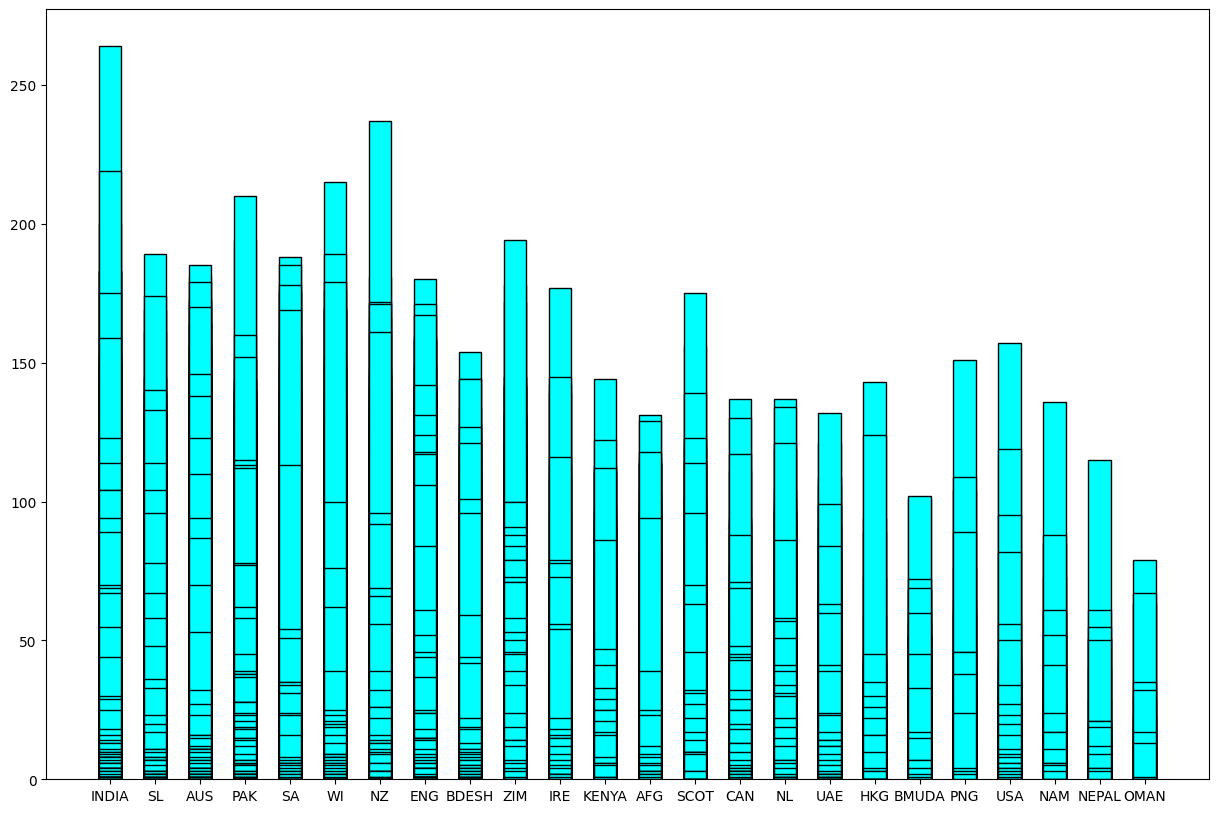

In [ ]:
#plotting
plt.figure(figsize=(15,10))
# plt.bar(odi['Final Region'], odi['HS'], color='red')
plt.bar(odi['Final Region'], odi['HS'], color='cyan', width=0.5, edgecolor='black')

<Figure size 2000x500 with 0 Axes>

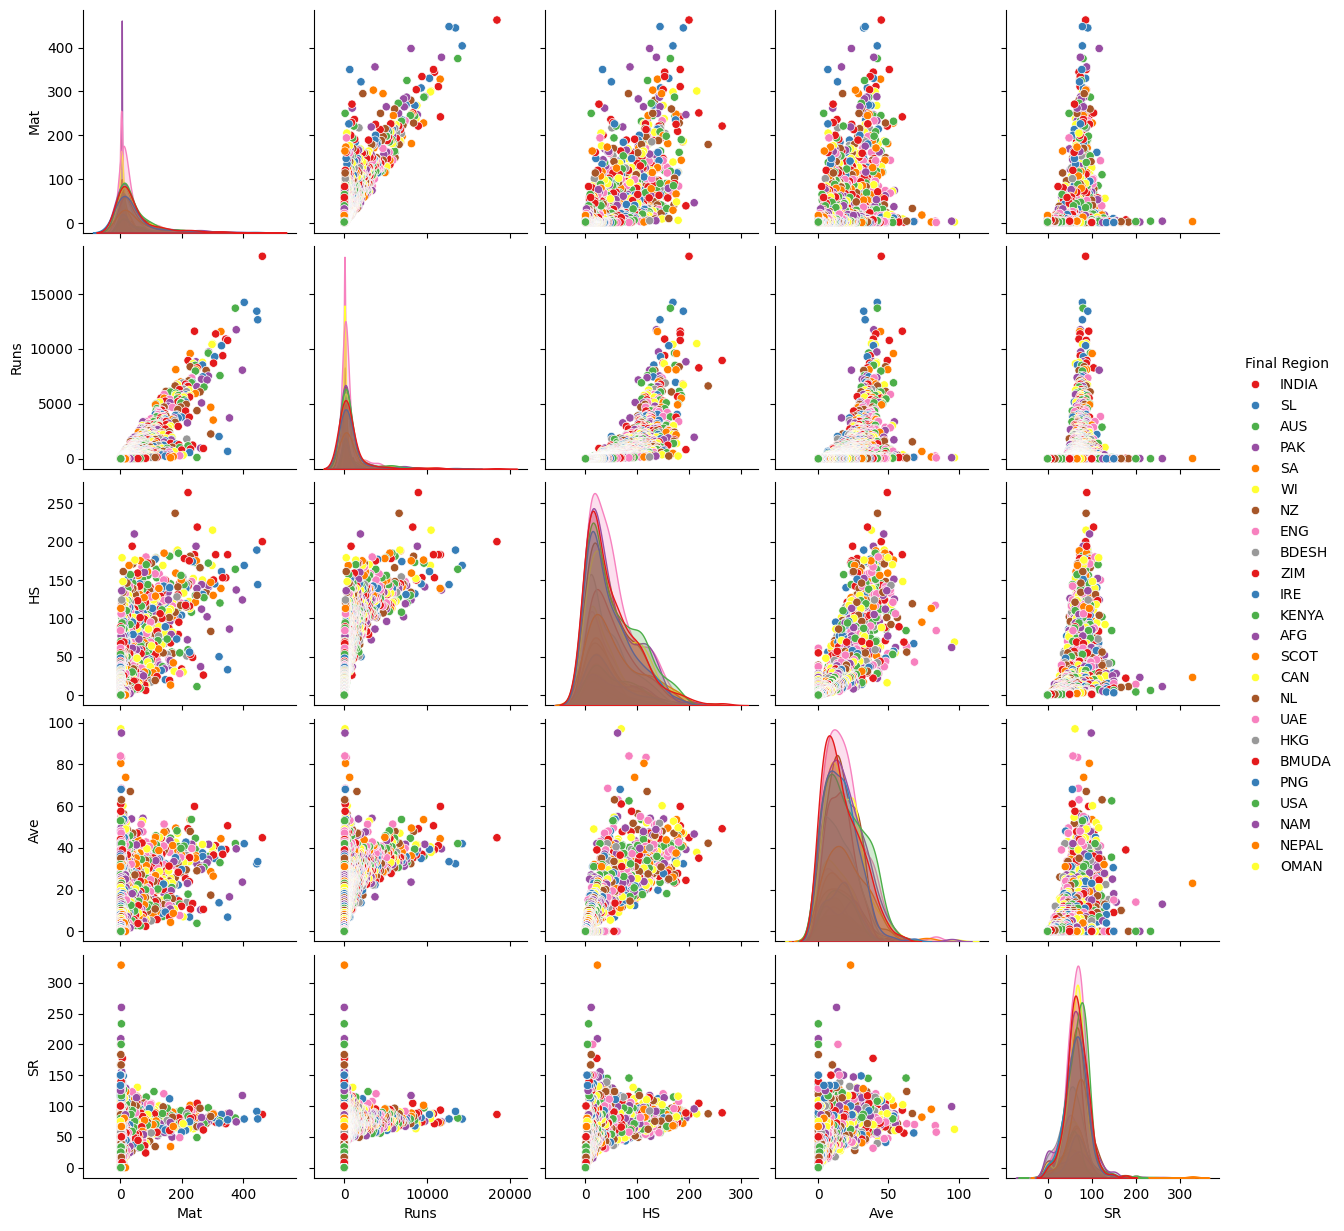

In [ ]:
#plotting the players attributes
plt.figure(figsize=(20,5))
sns.pairplot(odi, hue='Final Region', palette='Set1')

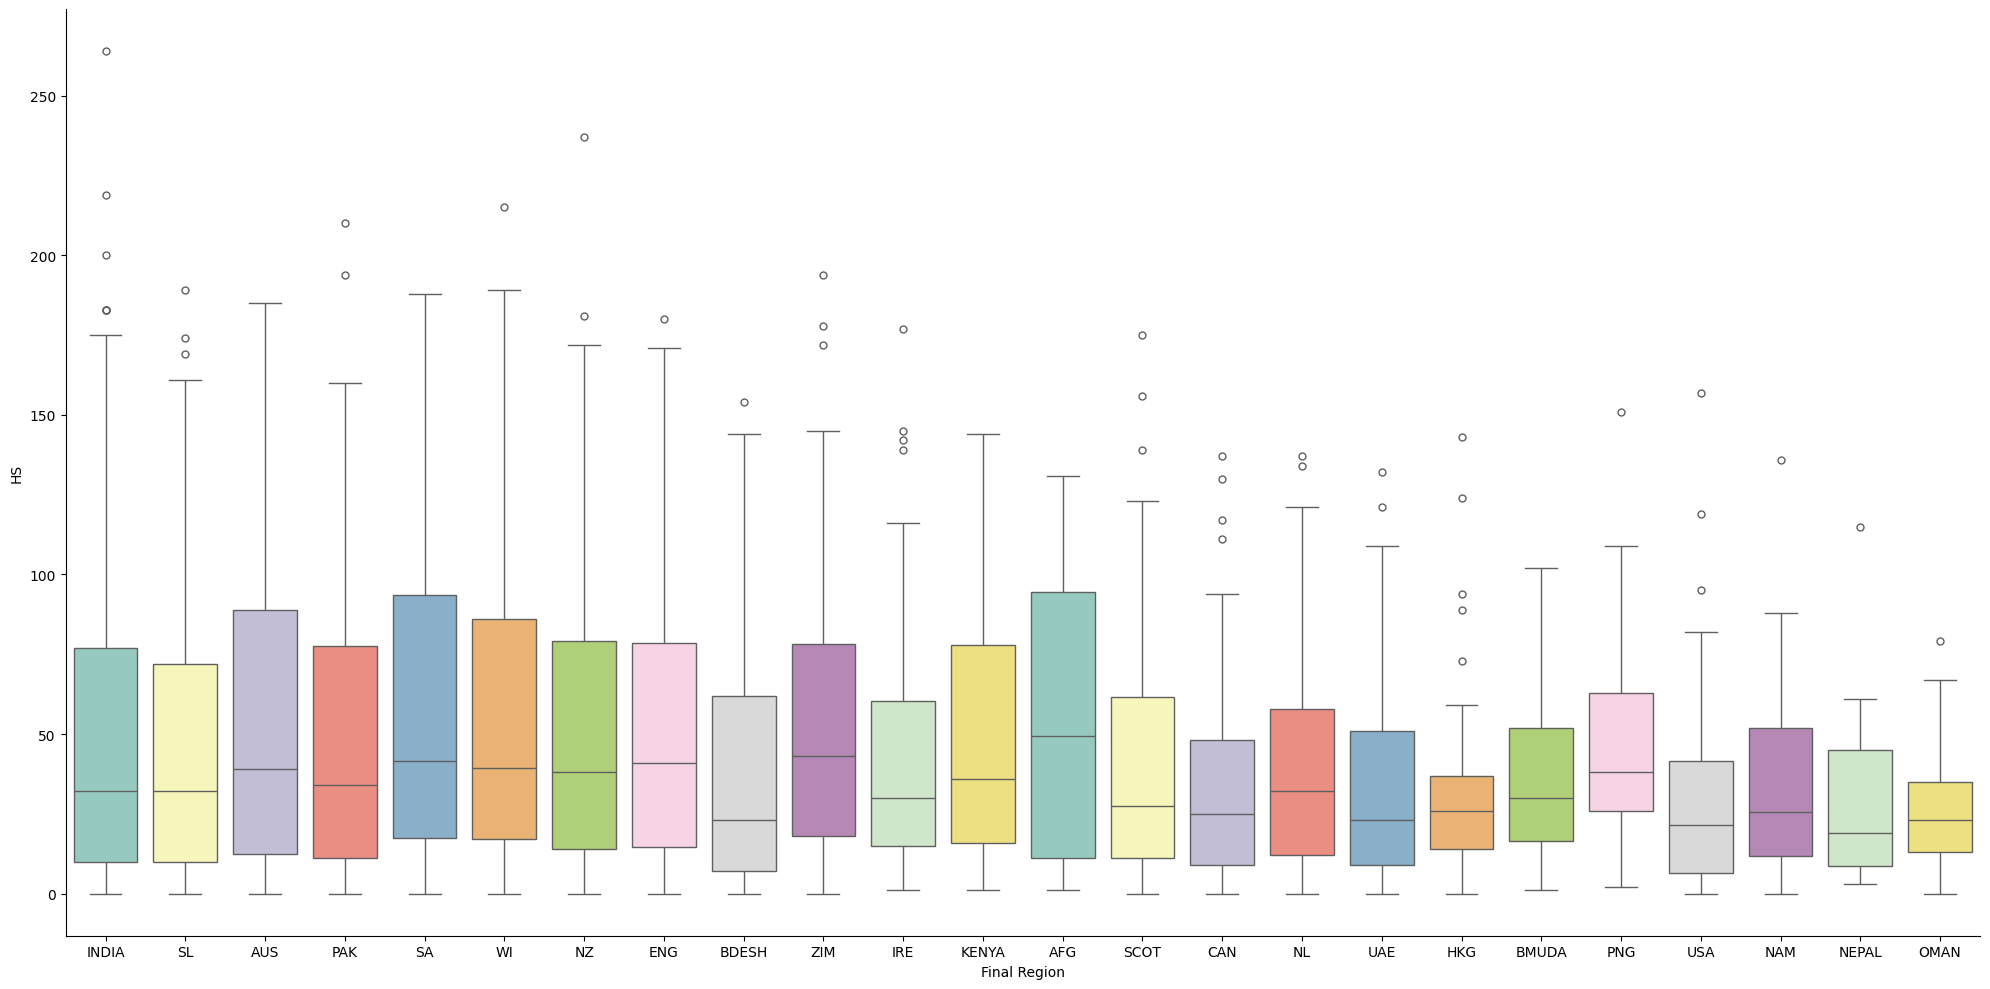

In [ ]:
sns.catplot(x='Final Region', y='HS', data=odi, kind='box', palette='Set3', height=10, aspect=2)

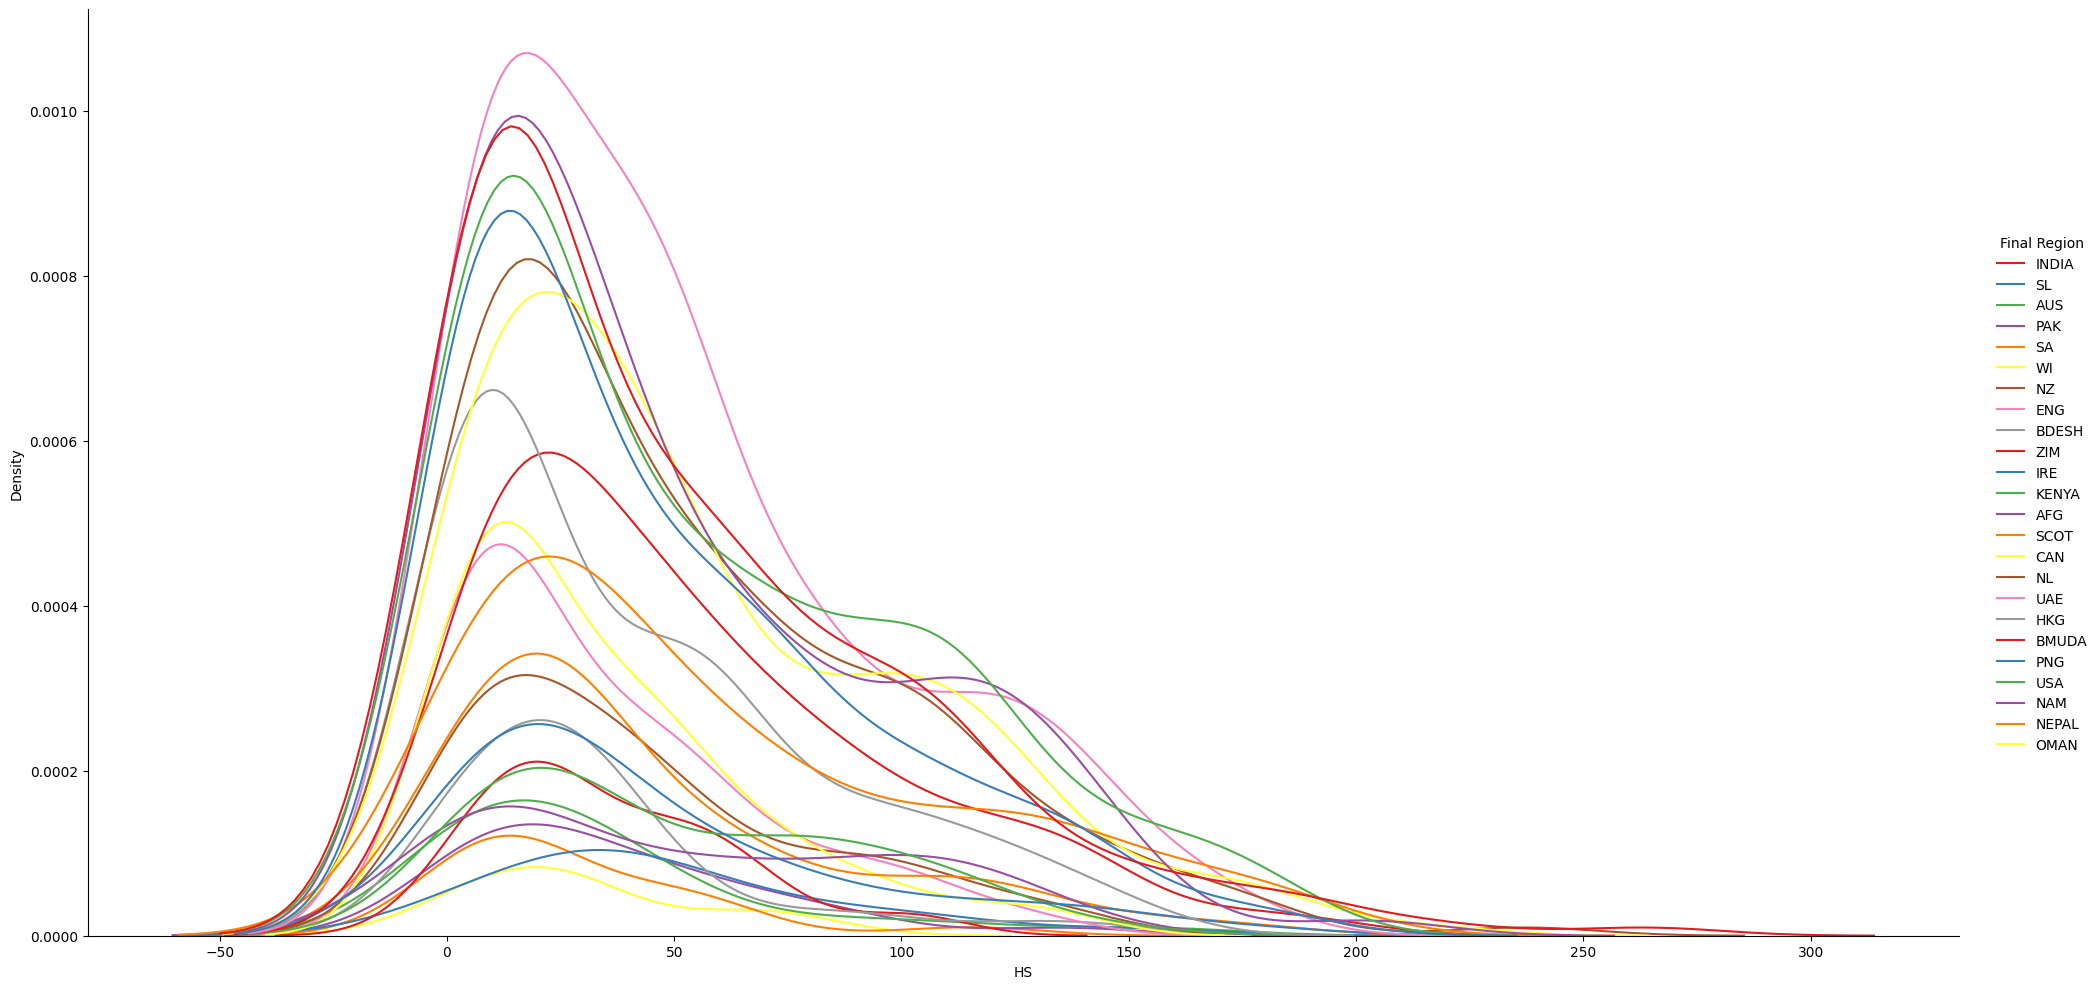

In [ ]:
sns.displot(odi, x='HS', hue='Final Region', kind='kde', palette='Set1', height=10, aspect=2)

In [ ]:
# In this plot we check the player HS, region, span and runs when we move cursor on any one circle, they show the related information
import plotly.express as px
px.scatter(odi, x="HS", y="Player", animation_frame="End", animation_group="Final Region",
          size="Runs", color="Final Region", hover_name="Final Region",
           log_x=False, size_max=200, range_x=[10,250], range_y=[0,90], height=1000)

# **6. Selecting features and split data into training and testing**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# # Selecting features (independent variables) and target (dependent variable)
features = ['Mat', 'Inns', 'Runs', 'HS','BF', 'SR','100', '50', '0']  # Features used for prediction
target = 'Ave'  # Target variable (average)

# # Splitting data into features (X) and target (y)
X = odi[features]
y = odi[target]

# # Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the number of samples in the training and testing sets
print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])

Number of training samples: 1988
Number of testing samples: 497


# **7. Machine Learning Model**

*   Linear Regression
*   Decision Tree
*   KNeighbor
*   Random Forest

## **Linear Regression**

In [ ]:
# # Training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# # Making predictions on the testing set
y_pred1 = model.predict(X_test)

# # Calculating accuracy (MSE) of the model
mse = mean_squared_error(y_test, y_pred1)
lr_accuracy = 1 - (mse / y_test.var())
print("Model Accuracy:", lr_accuracy)

Model Accuracy: 0.697225728850281


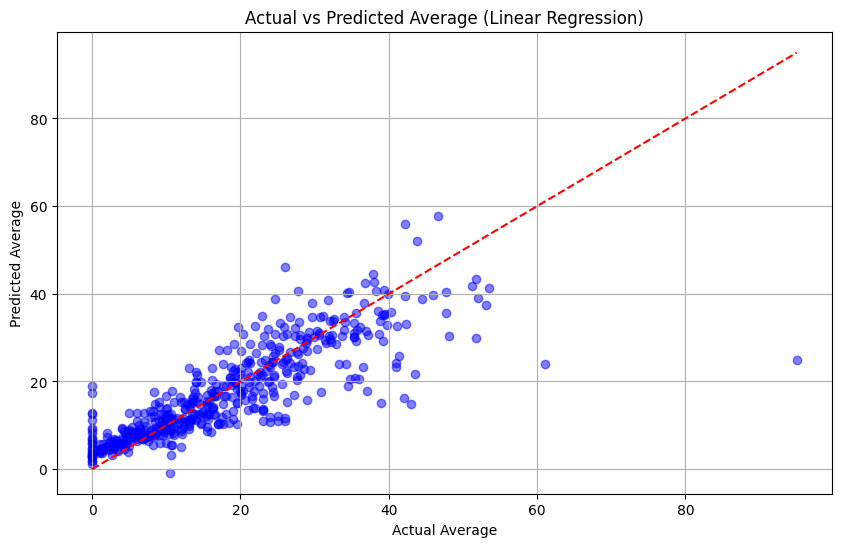

In [ ]:
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred1, color='blue', alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line representing perfect prediction
plt.xlabel('Actual Average')
plt.ylabel('Predicted Average')
plt.title('Actual vs Predicted Average (Linear Regression)')
plt.grid(True)
plt.show()

Precision: 0.7125
Recall: 0.6785714285714286
F1 Score: 0.6951219512195121


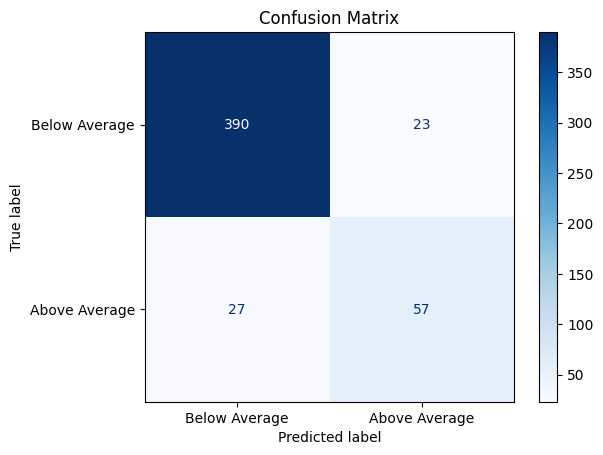

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Define a threshold for classification
threshold = 30

# Convert the regression predictions to binary classifications
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred1 > threshold).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# Print precision, recall, and F1 score
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Below Average', 'Above Average'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Identify players who are actually above average and predicted above average
actual_above_avg = y_test_binary == 1
predicted_above_avg = y_pred_binary == 1
correctly_classified = actual_above_avg & predicted_above_avg

# Print the names and actual averages of the correctly classified players
correctly_classified_players = X_test.index[correctly_classified]
correctly_classified_data = odi.loc[correctly_classified_players, ['Player', 'Ave']]

# Sort the correctly classified players by their actual average in descending order
sorted_correctly_classified_data = correctly_classified_data.sort_values(by='Ave', ascending=False)

# Print the top 11 players
print("Top 11 Players who are actually above average and predicted above average:")
print(sorted_correctly_classified_data.head(11))


Top 11 Players who are actually above average and predicted above average:
                 Player    Ave
43            MG Bevan   53.58
498     Rameez Shahzad   53.15
485           N Pooran   52.00
443      Anshuman Rath   51.75
163          IJL Trott   51.25
507        IM Chappell   48.07
966           Abid Ali   47.75
433           DL Amiss   47.72
233       Fakhar Zaman   46.61
756  KJJ van Noortwijk   46.00
73            S Dhawan   44.50


## **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# # Train Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

# # Make predictions
dt_y_pred = dt_regressor.predict(X_test)

# # Calculate accuracy
dt_mse = mean_squared_error(y_test, dt_y_pred)
dt_accuracy = 1 - (dt_mse / y_test.var())
print("Decision Tree Regressor Accuracy:", dt_accuracy)

Decision Tree Regressor Accuracy: 0.5960776428280611


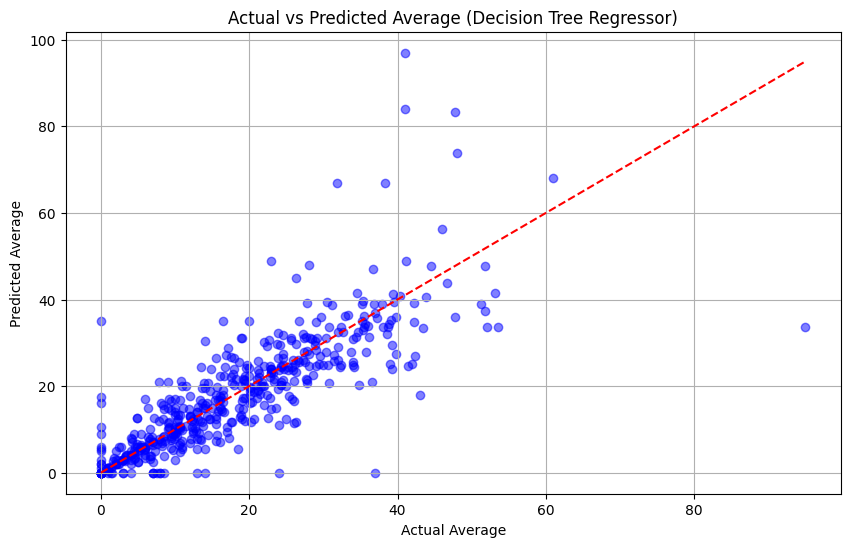

In [ ]:
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, dt_y_pred, color='blue', alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line representing perfect prediction
plt.xlabel('Actual Average')
plt.ylabel('Predicted Average')
plt.title('Actual vs Predicted Average (Decision Tree Regressor)')
plt.grid(True)
plt.show()

Precision: 0.6941176470588235
Recall: 0.7023809523809523
F1 Score: 0.6982248520710058


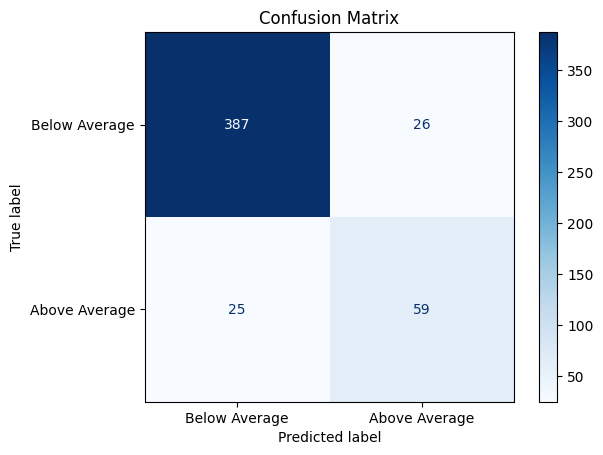

In [ ]:
# Convert the regression predictions to binary classifications
y_test_binary = (y_test > threshold).astype(int)
dt_y_pred_binary = (dt_y_pred > threshold).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_binary, dt_y_pred_binary)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_binary, dt_y_pred_binary)
recall = recall_score(y_test_binary, dt_y_pred_binary)
f1 = f1_score(y_test_binary, dt_y_pred_binary)

# Print precision, recall, and F1 score
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Below Average', 'Above Average'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Identify players who are actually above average and predicted above average
actual_above_avg = y_test_binary == 1
predicted_above_avg = dt_y_pred_binary == 1
correctly_classified = actual_above_avg & predicted_above_avg

# Print the names and actual averages of the correctly classified players
correctly_classified_players = X_test.index[correctly_classified]
correctly_classified_data = odi.loc[correctly_classified_players, ['Player', 'Ave']]

# Sort the correctly classified players by their actual average in descending order
sorted_correctly_classified_data = correctly_classified_data.sort_values(by='Ave', ascending=False)

# Print the top 11 players
print("Top 11 Players who are actually above average and predicted above average:")
print(sorted_correctly_classified_data.head(11))

Top 11 Players who are actually above average and predicted above average:
               Player    Ave
1274     Aamer Yamin   95.00
1166     CRM Douglas   61.00
43          MG Bevan   53.58
498   Rameez Shahzad   53.15
485         N Pooran   52.00
941        MHW Papps   51.75
443    Anshuman Rath   51.75
163        IJL Trott   51.25
507      IM Chappell   48.07
966         Abid Ali   47.75
433         DL Amiss   47.72


## **KNeighbor Regressor**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# # Train KNeighbors Regressor
knn_regressor = KNeighborsRegressor()
knn_regressor.fit(X_train, y_train)

# # Make predictions
knn_y_pred = knn_regressor.predict(X_test)

# # Calculate accuracy
knn_mse = mean_squared_error(y_test, knn_y_pred)
knn_accuracy = 1 - (knn_mse / y_test.var())
print("KNeighbors Regressor Accuracy:", knn_accuracy)

KNeighbors Regressor Accuracy: 0.687533069178884


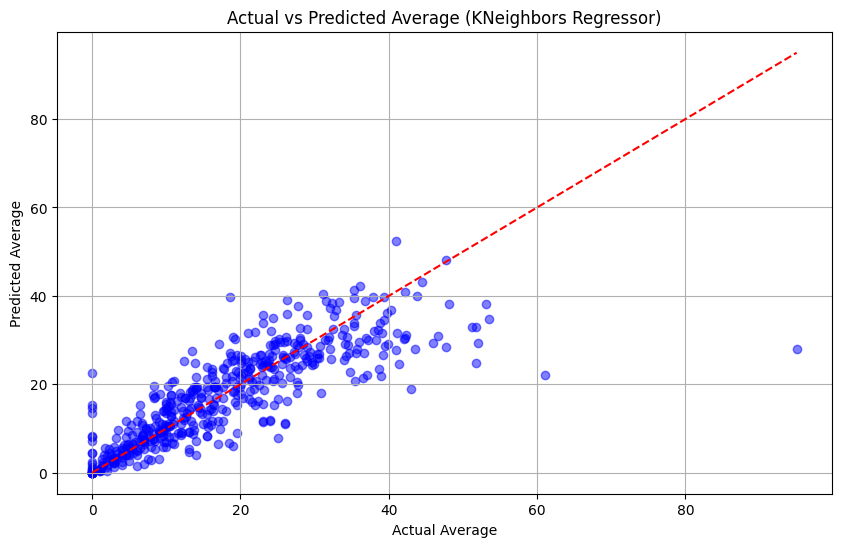

In [ ]:
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, knn_y_pred, color='blue', alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line representing perfect prediction
plt.xlabel('Actual Average')
plt.ylabel('Predicted Average')
plt.title('Actual vs Predicted Average (KNeighbors Regressor)')
plt.grid(True)
plt.show()

Precision: 0.71875
Recall: 0.5476190476190477
F1 Score: 0.6216216216216217


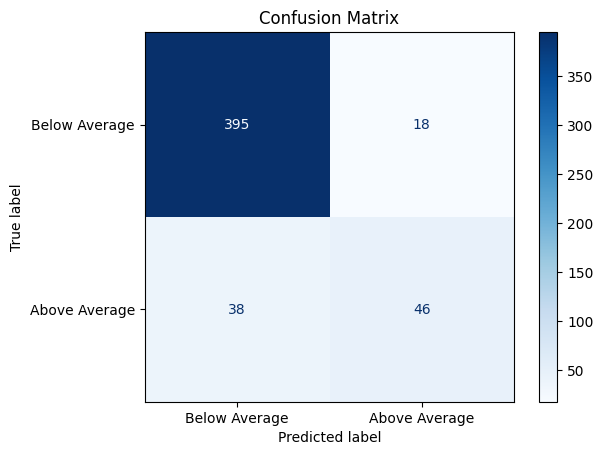

In [ ]:
# Convert the regression predictions to binary classifications
y_test_binary = (y_test > threshold).astype(int)
knn_y_pred_binary = (knn_y_pred > threshold).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_binary, knn_y_pred_binary)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_binary, knn_y_pred_binary)
recall = recall_score(y_test_binary, knn_y_pred_binary)
f1 = f1_score(y_test_binary, knn_y_pred_binary)

# Print precision, recall, and F1 score
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Below Average', 'Above Average'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Identify players who are actually above average and predicted above average
actual_above_avg = y_test_binary == 1
predicted_above_avg = knn_y_pred_binary == 1
correctly_classified = actual_above_avg & predicted_above_avg

# Print the top 11 names and actual averages of the correctly classified players
correctly_classified_players = X_test.index[correctly_classified]
correctly_classified_data = odi.loc[correctly_classified_players, ['Player', 'Ave']]

# Sort the correctly classified players by their actual average in descending order
sorted_correctly_classified_data = correctly_classified_data.sort_values(by='Ave', ascending=False)

# Print the top 11 players
print("Top 11 Players who are actually above average and predicted above average:")
print(sorted_correctly_classified_data.head(11))

Top 11 Players who are actually above average and predicted above average:
              Player    Ave
43         MG Bevan   53.58
498  Rameez Shahzad   53.15
443   Anshuman Rath   51.75
163       IJL Trott   51.25
507     IM Chappell   48.07
966        Abid Ali   47.75
233    Fakhar Zaman   46.61
73         S Dhawan   44.50
56        ML Hayden   43.80
420        KL Rahul   42.33
134    HH Dippenaar   42.23


## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# # Train Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

# # Make predictions
rf_y_pred = rf_regressor.predict(X_test)

# # Calculate accuracy
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_accuracy = 1 - (rf_mse / y_test.var())
print("Random Forest Regressor Accuracy:", rf_accuracy)

Random Forest Regressor Accuracy: 0.8159521040369274


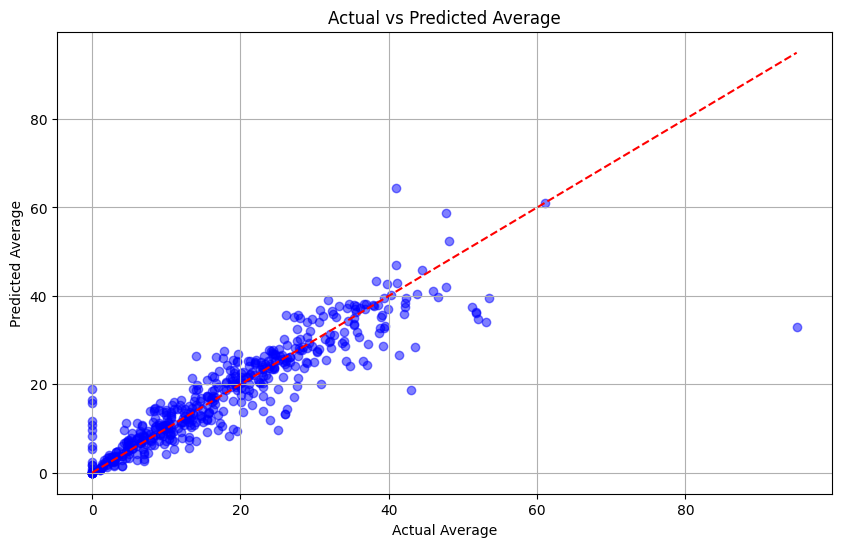

In [ ]:
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_y_pred, color='blue', alpha=0.5)  # Scatter plot of actual vs predicted values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line representing perfect prediction
plt.xlabel('Actual Average')
plt.ylabel('Predicted Average')
plt.title('Actual vs Predicted Average')
plt.grid(True)
plt.show()

Precision: 0.8533333333333334
Recall: 0.7619047619047619
F1 Score: 0.8050314465408804


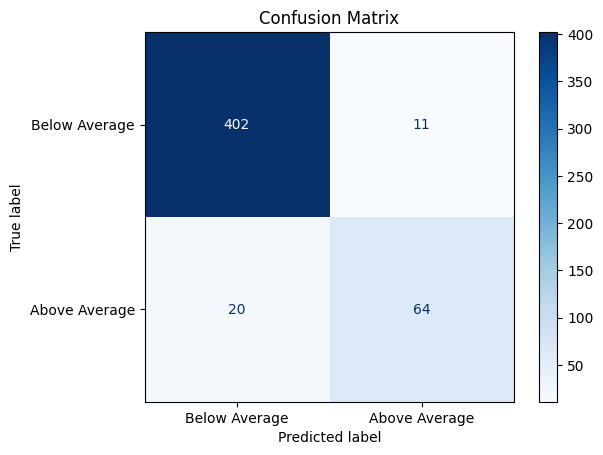

In [ ]:
# Convert the regression predictions to binary classifications
y_test_binary = (y_test > threshold).astype(int)
rf_y_pred_binary = (rf_y_pred > threshold).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_binary, rf_y_pred_binary)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_binary, rf_y_pred_binary)
recall = recall_score(y_test_binary, rf_y_pred_binary)
f1 = f1_score(y_test_binary, rf_y_pred_binary)

# Print precision, recall, and F1 score
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Below Average', 'Above Average'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Identify players who are actually above average and predicted above average
actual_above_avg = y_test_binary == 1
predicted_above_avg = rf_y_pred_binary == 1
correctly_classified = actual_above_avg & predicted_above_avg

# Print the names and actual averages of the correctly classified players
correctly_classified_players = X_test.index[correctly_classified]
correctly_classified_data = odi.loc[correctly_classified_players, ['Player', 'Ave']]

# Sort the correctly classified players by their actual average in descending order
sorted_correctly_classified_data = correctly_classified_data.sort_values(by='Ave', ascending=False)

# Print the top 11 players
print("Top 11 Players who are actually above average and predicted above average:")
print(sorted_correctly_classified_data.head(11))

Top 11 Players who are actually above average and predicted above average:
               Player    Ave
1274     Aamer Yamin   95.00
1166     CRM Douglas   61.00
43          MG Bevan   53.58
498   Rameez Shahzad   53.15
485         N Pooran   52.00
443    Anshuman Rath   51.75
941        MHW Papps   51.75
163        IJL Trott   51.25
507      IM Chappell   48.07
966         Abid Ali   47.75
433         DL Amiss   47.72


## **Comparison of model using barplot**

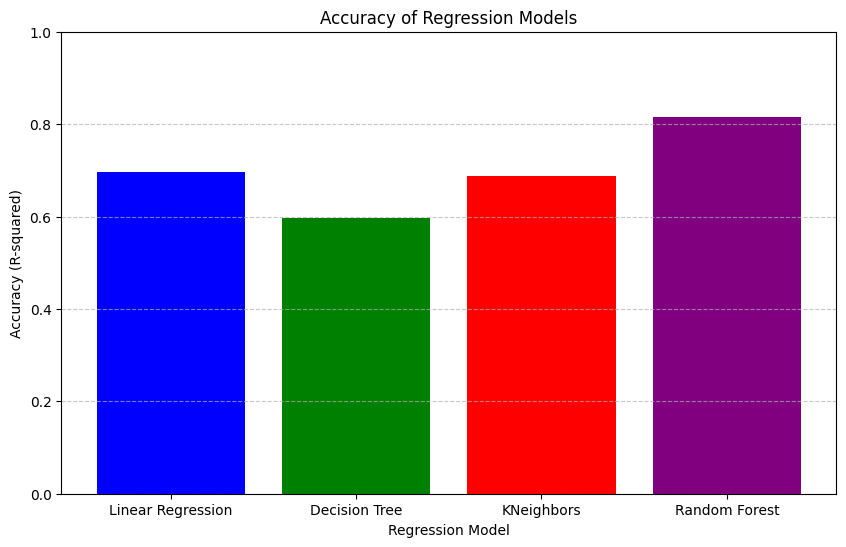

In [ ]:
# # Model names
models = ['Linear Regression', 'Decision Tree', 'KNeighbors', 'Random Forest']

# # Model accuracies
accuracies = [lr_accuracy, dt_accuracy, knn_accuracy, rf_accuracy]

# # Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Regression Model')
plt.ylabel('Accuracy (R-squared)')
plt.title('Accuracy of Regression Models')
plt.ylim(0, 1)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 8. Convert dataset into undirected graphical form

Below cell output shows the graphical form of our data, we only plot few players of ervey region with different color to visualize the graph.

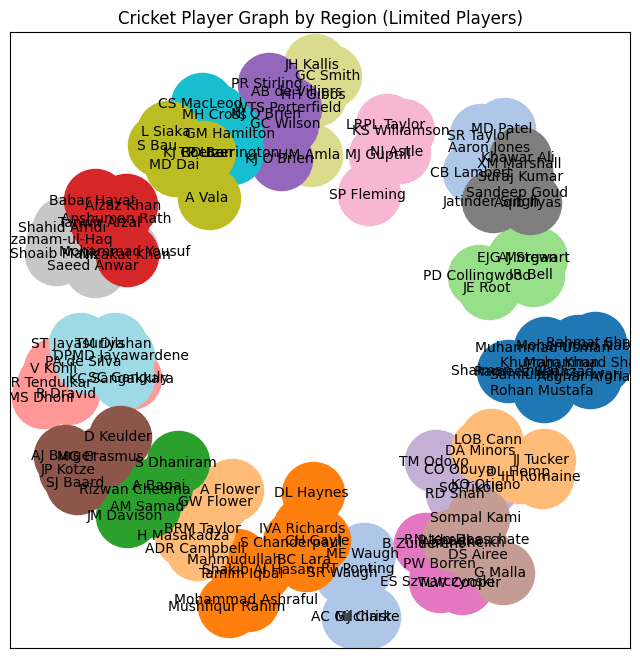

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create an empty graph
G = nx.Graph()

# Define the maximum number of players per region
max_players_per_region = 5

# Iterate through regions
for region in odi['Final Region'].unique():
    # Select players from the current region
    players_in_region = odi.loc[odi['Final Region'] == region, 'Player'].tolist()[:max_players_per_region]

    # Add nodes with player names and their statistics as node attributes
    for player_name in players_in_region:
        player_data = odi.loc[odi['Player'] == player_name].iloc[0]  # Assuming player names are unique
        G.add_node(player_name, Mat=player_data['Mat'], Inns=player_data['Inns'], Runs=player_data['Runs'],
                   HS=player_data['HS'], Ave=player_data['Ave'], SR=player_data['SR'], region=region)

    # Add edges between players based on the region they belong to
    for i, player1 in enumerate(players_in_region):
        for player2 in players_in_region[i+1:]:
            if not G.has_edge(player1, player2):
                G.add_edge(player1, player2, region=region)

# Get unique regions and assign a color to each region
unique_regions = list(nx.get_node_attributes(G, 'region').values())
unique_regions = sorted(list(set(unique_regions)))
num_regions = len(unique_regions)

# Create a custom color map with a unique color for each region
tab20_colors = plt.cm.tab20.colors
region_color_mapping = {region: tab20_colors[i % len(tab20_colors)] for i, region in enumerate(unique_regions)}
custom_cmap = ListedColormap(list(region_color_mapping.values()))

# Visualize the graph with each region's nodes having a different color
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.3, iterations=50)
for node, data in G.nodes(data=True):
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=region_color_mapping[data['region']], node_size=2000)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
for u, v, data in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=region_color_mapping[data['region']], width=1.0, alpha=0.5)
plt.title("Cricket Player Graph by Region (Limited Players)")
plt.show()


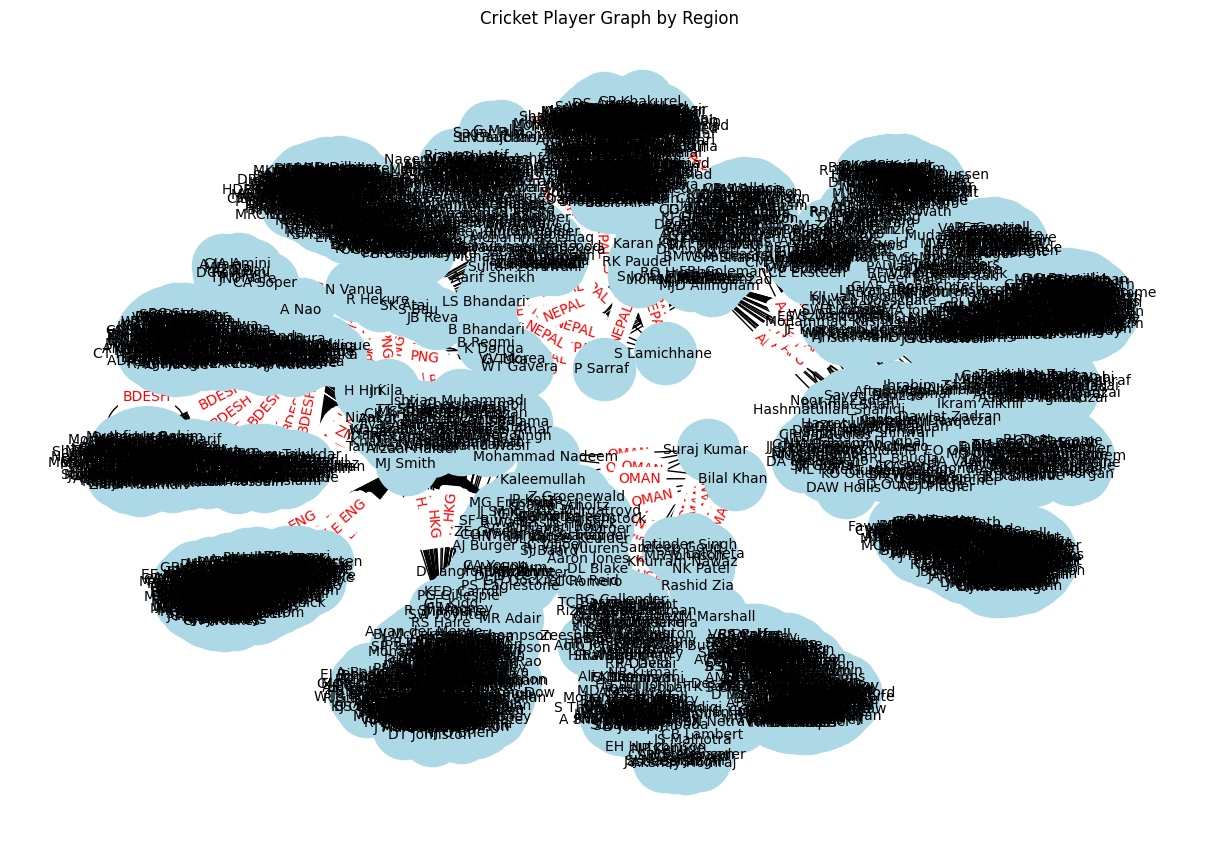

In [ ]:
# Create an empty graph
G = nx.Graph()

# Add nodes with player names and their statistics as node attributes
for index, row in odi.iterrows():
    player_name = row['Player']
    G.add_node(player_name, Mat=row['Mat'], Inns=row['Inns'], Runs=row['Runs'], HS=row['HS'], Ave=row['Ave'], SR=row['SR'])

# Add edges between players based on the region they belong to
for index, row in odi.iterrows():
    region = row['Final Region']
    players_in_region = odi.loc[odi['Final Region'] == region, 'Player'].tolist()
    for i, player1 in enumerate(players_in_region):
        for player2 in players_in_region[i+1:]:
            if not G.has_edge(player1, player2):
                G.add_edge(player1, player2, region=region)

# Now you have a graph where players are nodes with statistics as node attributes
# and edges represent regions

# Visualize the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10)
edge_labels = nx.get_edge_attributes(G, 'region')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title("Cricket Player Graph by Region")
plt.show()

# **Data manipulation**

In [ ]:
threshold = 35  # Define threshold for "good" players
for index, row in odi.iterrows():
    player_name = row['Player']
    is_good = 1 if row['Ave'] > threshold else 0
    G.nodes[player_name]['is_good'] = is_good

In [ ]:
data = from_networkx(G)
data.y = torch.tensor([node['is_good'] for _, node in G.nodes(data=True)], dtype=torch.long)

In [ ]:
features = [[node['Runs'],node['HS'],node['SR']] for _, node in G.nodes(data=True)]
data.x = torch.tensor(features, dtype=torch.float)

# **Graph Convolutional Networks (GCN)**

In [ ]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.out = GCNConv(hidden_dim, 2)  # Two output classes

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.out(x, edge_index)
        return F.log_softmax(x, dim=1)

# **Spliting the data**

In [ ]:
# Split data into train and test sets
train_idx, test_idx = train_test_split(range(len(data.y)), test_size=0.2)
data.train_mask = torch.zeros(len(data.y), dtype=torch.bool)
data.train_mask[train_idx] = 1
data.test_mask = torch.zeros(len(data.y), dtype=torch.bool)
data.test_mask[test_idx] = 1

# **Train the model**

In [ ]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=data.num_features, hidden_dim=64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


In [ ]:
# Train the model
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')


Epoch 0, Loss: 23.3580
Epoch 20, Loss: 3.8288
Epoch 40, Loss: 1.6522
Epoch 60, Loss: 0.6304
Epoch 80, Loss: 1.3675
Epoch 100, Loss: 1.4808
Epoch 120, Loss: 1.5258
Epoch 140, Loss: 0.6715
Epoch 160, Loss: 0.4689
Epoch 180, Loss: 0.4215


In [ ]:
# Evaluate the model
model.eval()
_, pred = model(data.x, data.edge_index).max(dim=1)
accuracy = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.8952


# **Result Visualization**

In [ ]:
# Visualize the graph with nodes colored based on performance category
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3, iterations=50)
colors = ['lightblue' if G.nodes[node]['is_good'] == 1 else 'salmon' for node in G.nodes]
nx.draw(G, pos, node_size=100, node_color=colors, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'region')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title("Cricket Player Graph by Region")
plt.show()

In [ ]:
# Model names
models = ['Linear Regression', 'Decision Tree', 'KNeighbors', 'Random Forest', 'GCN']

# # Model accuracies
accuracies = [lr_accuracy, dt_accuracy, knn_accuracy, rf_accuracy, accuracy]

# # Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
